In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

### Loading data

In [2]:
data = pd.read_excel('data.xlsx')
data.columns
data['nr_days'] = data['End_date'] - data['Start_date']
data['price'] = data['price'] / 100
data['coupon'] = data['coupon']/100
data['nr_years'] = data['nr_days'].apply(lambda x: int(x / np.timedelta64(1,'D'))) / 360
data

,price,month,coupon,Coupons pr year,Start_date,End_date,nr_days,nr_years
0,1.00021,1,0.0000,1,2017-02-02,2017-02-15,13 days,0.036111
1,1.00626,12,0.0000,1,2017-02-03,2017-12-15,315 days,0.875000
2,1.01397,24,0.0000,1,2017-02-04,2018-12-14,678 days,1.883333
3,1.00153,3,0.0000,1,2017-02-05,2017-04-12,66 days,0.183333
4,1.02142,36,0.0000,1,2017-02-06,2020-04-17,1166 days,3.238889
5,1.01776,60,0.0000,1,2017-02-07,2022-04-08,1886 days,5.238889
6,1.00411,6,0.0000,1,2017-02-08,2017-07-26,168 days,0.466667
7,1.10358,72,0.0150,1,2017-02-09,2023-02-15,2197 days,6.102778
8,1.03233,96,0.0050,1,2017-02-10,2025-02-15,2927 days,8.130556
9,0.98297,120,0.0025,1,2017-02-11,2027-02-15,3656 days,10.155556


In [3]:
def ListOfPeriods(n, T, t=0):
    
    last_coupon = int(np.floor(n*(T-t)))
    period_adder = n*(T-t) - last_coupon
    
    return [(i + period_adder)/n  for i in range(1, last_coupon + 1)]


def BondPrice(c, n, T, ys, t=0):
    
    """Returns price, for given YTM"""  
    
    LOP = ListOfPeriods(n, T, t=t)
    
    discounted_coupons = [(c/n) * np.exp(-(i-t)*(ys)) for i in LOP]
    FV = np.exp(-(T-t)*(ys))
    
    B = np.sum(discounted_coupons) + FV
    return B


def YTM(B, c, n, T, t=0, ys_guess=0.01):
    
    def ObjectiveFunc(ys):
    
        return (B - BondPrice(c, n, T, ys, t=t))**2
    
    bound_ys = [(-1 , 1)]
    
    solution = minimize(fun= ObjectiveFunc, x0=ys_guess, method='SLSQP', bounds=bound_ys)
    
    return solution.x[0]

In [4]:
data['YTM'] = data.apply(lambda x: YTM(B = x['price'], c=x['coupon'], n= x['Coupons pr year'], T = x['nr_years']), axis=1)

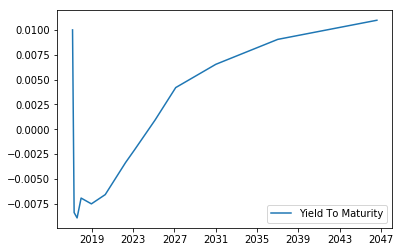

In [5]:
f, ax = plt.subplots(1,1)
data.sort_values('End_date', inplace=True)
ax.plot(data['End_date'], data['YTM'], label='Yield To Maturity')
ax.legend()
plt.savefig('YTM.png')

# Question 2

In [6]:
class NielsonSiegelModel(object):
    
    def __init__(self):
        pass
    
    @staticmethod
    def NielsonSiegel(b1, b2, b3, lam1, T):
    
        return b1 + b2*((1-np.exp(-T/lam1))/(T/lam1)) + b3*(((1-np.exp(-T/lam1))/(T/lam1))-np.exp(-T/lam1))
    

    def VectorRates(self, b1, b2, b3, lam1, vector_T):
    
        """ Returns vector of rates"""
        return [self.NielsonSiegel(b1, b2, b3, lam1, Ti) for Ti in vector_T]
    
    
    def VectorPrices(self, vector_c, vector_n, vector_T, vector_r):

        list_of_prices = []
        for i in range(len(vector_c)):
            c, n, T, ys = vector_c[i], vector_n[i], vector_T[i], vector_r[i]

            list_of_prices.append(BondPrice(c, n, T, ys, t=0))

        return list_of_prices
    
    def NSM(self, data, x_guess):

        """
        x_guess: (list)
        =======
        b1 = x[0]
        b2 = x[1]
        b3 = x[2]
        lam1 = x[3]

        =======
        returns : vector of x
        """

        vector_c, vector_n, vector_T, vector_p_market = data['coupon'], data['Coupons pr year'], data['nr_years'], data['price']

        def ObjectiveFunc(x):
            b1 = x[0]
            b2 = x[1]
            b3 = x[2]
            lam1 = x[3]

            vector_r = self.VectorRates(b1, b2, b3, lam1, vector_T) # vector_r is endogenous
            vector_p_model = self.VectorPrices(vector_c, vector_n, vector_T, vector_r)

            res = np.sum(np.array(np.array(vector_p_market) - np.array(vector_p_model))**2)
            return res

        bound=[(-2,2),(-2,2),(-30,30),(-30,30)]

        solution = minimize(fun= ObjectiveFunc, x0=x_guess, method='SLSQP', bounds=bound)

        return solution


In [7]:
x_guess = [0.01, -0.01, 0 , 2]
NSM = NielsonSiegelModel()
sol = NSM.NSM(data, x_guess)
x_list = list(sol.x)
b1, b2, b3, lam1 = x_list[0], x_list[1], x_list[2], x_list[3]
print('b1: ',b1,'b2: ',b2,'b3: ',b3, 'lam1:', lam1)
b1_NS, b2_NS, b3_NS, lam1_NS = b1, b2, b3, lam1

b1:  0.014907040259 b2:  -0.0123318899496 b3:  -0.0468055972558 lam1: 2.00034667642


In [8]:
MeanSquaredErrorNelsonSiegel = sol.fun
print(MeanSquaredErrorNelsonSiegel)

0.00043023479318226665


/Users/Jeppe/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars


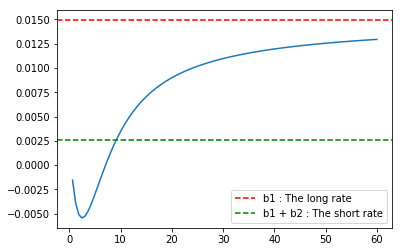

In [9]:
x_= np.linspace(0,60,num=100)
y_NSM = [NSM.NielsonSiegel(b1, b2, b3, lam1, i) for i in x_]

f, ax = plt.subplots(1,1)
ax.plot(x_, y_NSM)
ax.axhline(b1, label= 'b1 : The long rate', color='red', ls='--')
ax.axhline(b1+b2, label= 'b1 + b2 : The short rate', color='green', ls='--')
ax.legend()
plt.savefig('Nelson-Siegel.png')

In [10]:
class SvenssonModel(object):
    
    def __init__(self):
        pass
    
    @staticmethod
    def Svensson(b1, b2, b3, b4, lam1, lam2, T):
    
        return b1 + b2*((1-np.exp(-T/lam1))/(T/lam1)) + b3*(((1-np.exp(-T/lam1))/(T/lam1))-np.exp(-T/lam1)) + b4*(((1-np.exp(-T/lam2))/(T/lam2))-np.exp(-T/lam2))
    

    def VectorRates(self, b1, b2, b3, b4, lam1, lam2, vector_T):
    
        """ Returns vector of rates"""
        return [self.Svensson(b1, b2, b3, b4, lam1, lam2, Ti) for Ti in vector_T]
    
    
    def VectorPrices(self, vector_c, vector_n, vector_T, vector_r):

        list_of_prices = []
        for i in range(len(vector_c)):
            c, n, T, ys = vector_c[i], vector_n[i], vector_T[i], vector_r[i]

            list_of_prices.append(BondPrice(c, n, T, ys, t=0))

        return list_of_prices
    
    def SM(self, data, x_guess):

        """
        x_guess: (list)
        =======
        b1 = x[0]
        b2 = x[1]
        b3 = x[2]
        b4 = x[3]
        lam1 = x[4]
        lam2 = x[5]

        =======
        returns : vector of x
        """

        vector_c, vector_n, vector_T, vector_p_market = data['coupon'], data['Coupons pr year'], data['nr_years'], data['price']

        def ObjectiveFunc(x):
            b1 = x[0]
            b2 = x[1]
            b3 = x[2]
            b4 = x[3]
            lam1 = x[4]
            lam2 = x[5]

            vector_r = self.VectorRates(b1, b2, b3, b4, lam1, lam2, vector_T) # vector_r is endogenous
            vector_p_model = self.VectorPrices(vector_c, vector_n, vector_T, vector_r)

            res = np.sum(np.array(np.array(vector_p_market) - np.array(vector_p_model))**2)
            return res

        bound=[(-2,2),(-2,2),(-2,2),(-2,2), (-10,10),(-10,10)]

        solution = minimize(fun= ObjectiveFunc, x0=x_guess, method='SLSQP', bounds=bound)

        return solution


In [11]:
x_guess = [0.014, -0.012, -0.468, 0, 2, 2]
SM = SvenssonModel()
sol = SM.SM(data, x_guess)
x_list = list(sol.x)
b1, b2, b3, b4, lam1, lam2 = x_list[0], x_list[1], x_list[2], x_list[3], x_list[4], x_list[5]
b1_SM, b2_SM, b3_SM, b4_SM, lam1_SM, lam2_SM = b1, b2, b3, b4, lam1, lam2

/Users/Jeppe/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:57: RuntimeWarning: overflow encountered in square
/Users/Jeppe/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: overflow encountered in exp
/Users/Jeppe/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: overflow encountered in exp


In [12]:
print('b1 :', b1, 'b2 :', b2, 'b3 :', b3,'b4 :', b4, 'lam1 :', lam1, 'lam2', lam2)

b1 : 0.0150950624961 b2 : -0.0162137997828 b3 : 0.00360089378392 b4 : -0.0544871532228 lam1 : 0.865103815568 lam2 2.04083409494


In [13]:
MeanSquaredErrorSvensson = sol.fun
print(MeanSquaredErrorSvensson)

0.0003997039553169198


/Users/Jeppe/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars


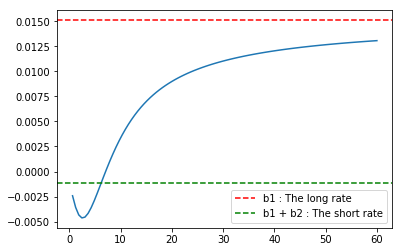

In [14]:
x_= np.linspace(0,60,num=100)
y_SM = [SvenssonModel.Svensson(b1, b2, b3, b4, lam1, lam2, i) for i in x_]

f, ax = plt.subplots(1,1)
ax.plot(x_, y_SM)
ax.axhline(b1, label= 'b1 : The long rate', color='red', ls='--')
ax.axhline(b1+b2, label= 'b1 + b2 : The short rate', color='green', ls='--')
ax.legend()
plt.savefig('Svensson.png')

In [15]:
x_compare = [1/52, 0.5, 1, 5, 10, 30]
SM_rates = [SvenssonModel.Svensson(b1_SM, b2_SM, b3_SM, b4_SM, lam1_SM, lam2_SM, i) for i in x_compare]
NS_rates = [NSM.NielsonSiegel(b1_NS, b2_NS, b3_NS, lam1_NS, i) for i in x_compare]

In [16]:
print(NS_rates)

[0.0024106873470304082, -0.00096489435833784724, -0.0032408950357681043, -0.0029654541346972024, 0.0034729156607906098, 0.010963873290849838]


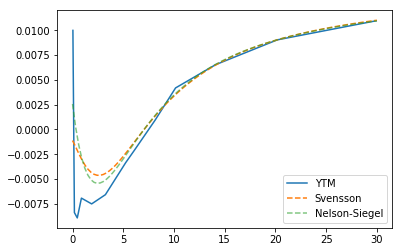

In [22]:
x_= np.linspace(0.00001,30,num=100)
SM_rates = [SvenssonModel.Svensson(b1_SM, b2_SM, b3_SM, b4_SM, lam1_SM, lam2_SM, i) for i in x_]
NS_rates = [NSM.NielsonSiegel(b1_NS, b2_NS, b3_NS, lam1_NS, i) for i in x_]

f, ax = plt.subplots(1,1)
ax.plot(data['nr_years'], data['YTM'])
ax.plot(x_, SM_rates, label = 'Svensson', ls='--')
ax.plot(x_, NS_rates, label = 'Nelson-Siegel', ls ='--', alpha=0.6)

ax.legend()
plt.savefig('ThreeFigures.png')

In [3]:
a = np.array([1,2,3])
b = np.array([1,1,1])

(a-b)**2

array([0, 1, 4])

In [7]:
isinstance(a, np.ndarray)

True

In [15]:
t_w = [a[i]*b[i] for i in range(len(a))] 

In [16]:
t_w

[1, 2, 3]

In [18]:
for i in xrange(a):
    print(i)

NameError: name 'xrange' is not defined

In [19]:
list_of_dicts = []

In [27]:
b1 = {'C' : 23, 'P' : 1, 'D' : 245, 'N' : 23}
b2 = {'C' : 21, 'P' : 1.05, 'D' : 200, 'N' : 44 } 

list_of_dicts = [b1, b2]

In [28]:
C = [i['C'] for i in list_of_dicts]
P = [i['P'] for i in list_of_dicts]
D = [i['D'] for i in list_of_dicts]
N = [i['N'] for i in list_of_dicts]



In [23]:
def Practical_immunization(self, list_of_dicts, C_l, D_l):
    
    C = [i['C'] for i in list_of_dicts]
    P = [i['P'] for i in list_of_dicts]
    D = [i['D'] for i in list_of_dicts]
    N = [i['N'] for i in list_of_dicts]
    
    minimize(objective_func, )
    
    
    
    

[23, 21]

In [24]:
P

[1, 1.05]

In [25]:
D

[245, 200]